In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
import collections
tf.logging.set_verbosity(tf.logging.ERROR)

/home/uttaran/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/uttaran/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
# %load Structural_Perturbations.py


# In[1]:


import cv2
import numpy as np
import tensorflow as tf


# In[2]:


def Exposure(eval_data,e):
    e = e/255
    for i in range(0,eval_data.shape[0]):
        eval_data[i][0:eval_data.shape[1] - 4]+=e
        eval_data[i] = eval_data[i].clip(min=0,max=1)
    return eval_data


# In[3]:


def Translation(eval_data,l):
    temp = np.asarray(eval_data)
    temp = np.reshape(temp,(-1,28,28))
    M = np.float32([[1,0,l],[0,1,0]])
    for i in range(0,eval_data.shape[0]):
        temp[i] = cv2.warpAffine(temp[i],M,(28,28))
        temp[i] = temp[i].clip(min=0,max=1)
    temp = np.reshape(temp,[eval_data.shape[0],eval_data.shape[1]])
    eval_data = temp
    return eval_data


# In[4]:


def Rotation(eval_data,angle):
    temp = eval_data.reshape(-1,28,28)
    s,r,c = temp.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),angle,1)
    for i in range (0,s):
        temp[i] = cv2.warpAffine(temp[i],M,(c,r))
        temp[i] = temp[i].clip(min=0,max=1)
    return temp.reshape(-1,eval_data.shape[1])


# In[5]:


def Scaling(eval_data,l):
    temp = eval_data.reshape(-1,28,28)
    s,r,c = temp.shape
    for i in range (0,s):
        img = cv2.resize(temp[i],None,fx=l, fy=l, interpolation = cv2.INTER_CUBIC)
        m = np.int((img.shape[0]-28)/2)
        temp[i] = img[m:m+28,m:m+28]
        temp[i] = temp[i].clip(min=0,max=1)
    return temp.reshape(-1,eval_data.shape[1])


# In[6]:


def Display(eval_data,t):
    l = np.array(eval_data[t])
    l = [int (x * 255) for x in l]
    l = np.asarray(l)
    l = np.reshape(l,(-1,28))
    plt.imshow(l,cmap='gray')


# In[7]:


def Plot(eval_data,eval_labels,mnist_classifier):
    eval_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": eval_data},
      y=eval_labels,
      num_epochs=1,
      shuffle=False)
    pred = mnist_classifier.predict(input_fn=eval_input_fn)
    my_array = []
    for i, x in enumerate(pred):
        temp = x['probabilities']
        pos = sorted(temp,reverse=True)
        index = [pos.index(v) for v in temp]
        my_array.append(index[eval_labels[i]])
    count = collections.Counter(my_array)
    keys = np.array(list(count.keys()))
    values = np.array(list(count.values()))
    grid = []
    for i in range(0,keys.shape[0]):
        grid.append([keys[i],values[i]])
    grid = np.array(grid)
    grid.view('i8,i8').sort(axis=0)
    plt.plot(grid)


# In[8]:


def Test(train_data,train_labels,eval_data,eval_labels,mnist_classifier):
    train_eval_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": train_data},
      y=train_labels,
      shuffle=False)
    eval_result1=mnist_classifier.evaluate(input_fn=train_eval_input_fn)
    print("%%%%%%% Train accuracy %%%%%%%%%%%%\n",eval_result1)
    [a,b,c] = eval_result1.items()

    # Evaluate the model and print results
    eval_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": eval_data},
      y=eval_labels,
      num_epochs=1,
      shuffle=False)
    eval_result2=mnist_classifier.evaluate(input_fn=eval_input_fn)
    print("######### Test accuracy #############\n",eval_result2)
    [d,e,f] = eval_result2.items()



In [8]:
# Load training and eval data
mnist = tf.contrib.learn.datasets.load_dataset("mnist")
train_data = mnist.train.images  # Returns np.array
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
eval_data = mnist.test.images  # Returns np.array
eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)
acc_track = []
pred_diff = []

Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


0.76470596


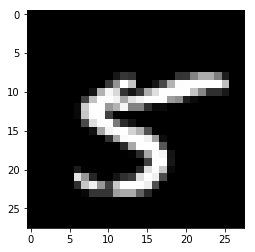

In [10]:
Display(eval_data,433)
print(eval_data[1000][433])

In [39]:
eval_data = Scaling(eval_data,1.5)

In [6]:
eval_data = Exposure(eval_data,+60)

In [ ]:
eval_data = Rotation(eval_data,30)

In [47]:
eval_data = Translation(eval_data,2)

In [ ]:
Display(eval_data,433)

In [6]:
def cnn_model_fn(features, labels, mode):
  """Model function for CNN."""
  # Input Layer
  # Reshape X to 4-D tensor: [batch_size, width, height, channels]
  # MNIST images are 28x28 pixels, and have one color channel
  input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])
  # Convolutional Layer #1
  # Computes 32 features using a 5x5 filter with ReLU activation.
  # Padding is added to preserve width and height.
  # Input Tensor Shape: [batch_size, 28, 28, 1]
  # Output Tensor Shape: [batch_size, 28, 28, 32]
  conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=32,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

  # Pooling Layer #1
  # First max pooling layer with a 2x2 filter and stride of 2
  # Input Tensor Shape: [batch_size, 28, 28, 32]
  # Output Tensor Shape: [batch_size, 14, 14, 32]
  pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

  # Convolutional Layer #2
  # Computes 64 features using a 5x5 filter.
  # Padding is added to preserve width and height.
  # Input Tensor Shape: [batch_size, 14, 14, 32]
  # Output Tensor Shape: [batch_size, 14, 14, 64]
  conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

  # Pooling Layer #2
  # Second max pooling layer with a 2x2 filter and stride of 2
  # Input Tensor Shape: [batch_size, 14, 14, 64]
  # Output Tensor Shape: [batch_size, 7, 7, 64]
  pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

  # Flatten tensor into a batch of vectors
  # Input Tensor Shape: [batch_size, 7, 7, 64]
  # Output Tensor Shape: [batch_size, 7 * 7 * 64]
  pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])

  # Dense Layer
  # Densely connected layer with 1024 neurons
  # Input Tensor Shape: [batch_size, 7 * 7 * 64]
  # Output Tensor Shape: [batch_size, 1024]
  dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)

  # Add dropout operation; 0.6 probability that element will be kept
  dropout = tf.layers.dropout(
      inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

  # Logits layer
  # Input Tensor Shape: [batch_size, 1024]
  # Output Tensor Shape: [batch_size, 10]
  logits = tf.layers.dense(inputs=dropout, units=10)
  #print(logits.shape)
  #temp = tf.nn.top_k(input=logits,k=1,sorted=True,name=None)
  #print(temp[0])
  predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      
      #"classes": temp,
      "classes":tf.argmax(input=logits, axis=1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
  }
  if mode == tf.estimator.ModeKeys.PREDICT:
    return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

  # Calculate Loss (for both TRAIN and EVAL modes)
  loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

  # Configure the Training Op (for TRAIN mode)
  if mode == tf.estimator.ModeKeys.TRAIN:
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
    train_op = optimizer.minimize(
        loss=loss,
        global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

  # Add evaluation metrics (for EVAL mode)
  eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"]),
  }
  return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [7]:
# Evaluate the model and print results
mnist_classifier = tf.estimator.Estimator(
  model_fn=cnn_model_fn, model_dir="./models/mnist_convnet_model_test1")

# Set up logging for predictions
# Log the values in the "Softmax" tensor with label "probabilities"
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(
  tensors=tensors_to_log, every_n_iter=50)

In [8]:
# print("started\n")
# # Train the model
# while 1:
#     curr_result = current_loss(0)
#     print(curr_result)
#     if curr_result[0] - curr_result[1] > 0.10 or curr_result[1] > 0.95:
#         break
# # Train the model
#     print("Training")
#     train_input_fn = tf.estimator.inputs.numpy_input_fn(
#       x={"x": train_data},
#       y=train_labels,
#       batch_size=256,
#       num_epochs=None,
#       shuffle=True)

#     mnist_classifier.train(
#       input_fn=train_input_fn,
#       steps=1,
#       hooks=[logging_hook])
    
#     #print(curr_result)
    
# print ("Finished")

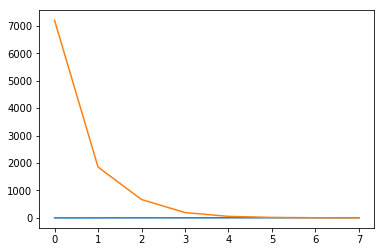

In [9]:
Plot(eval_data,eval_labels,mnist_classifier)

In [50]:
Test(train_data,train_labels,eval_data,eval_labels,mnist_classifier)

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.96958184, 'loss': 0.10504243, 'global_step': 20014}
######### Test accuracy #############
 {'accuracy': 0.8668, 'loss': 0.4016439, 'global_step': 20014}
